In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
import gpflux
import gpflow
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from sklearn.metrics import mean_squared_error, mean_absolute_error
from properscoring import crps_gaussian

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution_gpflux, percentage_outof_CI, number_outof_CI

tf.keras.backend.set_floatx("float64")

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)
x = x.numpy().reshape(-1,1)
y = y.numpy().reshape(-1,1)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

x_train = x_train.numpy().reshape(-1,1)
y_train = y_train.numpy().reshape(-1,1)
x_test = x_test.numpy().reshape(-1,1)
y_test = y_test.numpy().reshape(-1,1)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-24 20:45:46.767897: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-24 20:45:47.359042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


# Deep GP model

Let's first try running a two layer model to test the model.

inducing points = 1000 and RBF kernels for both layers.

In [14]:
def build_train_2layer_dgp(kernel1, kernel2, num_inducing=1000, batch_size=500):
    Z = np.linspace(x_train.min(), x_train.max(), num_inducing).reshape(-1, 1)

    # layer 1 set up
    inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer1 = gpflux.layers.GPLayer(
        kernel1, 
        inducing_variable1, 
        num_data=len(x_train), 
        num_latent_gps=y.shape[1]
    )

    # layer 2 set up
    inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer2 = gpflux.layers.GPLayer(
        kernel2,
        inducing_variable2,
        num_data=len(x_train),
        num_latent_gps=y.shape[1]
    )

    # model construction
    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
    two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)

    model = two_layer_dgp.as_training_model()
    model.compile(tf.optimizers.Adam(0.01))

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    ]
    history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=500, verbose=0, callbacks=callbacks)
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].plot(history.history["loss"])
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Objective = neg. ELBO")
    ax[0].set_title('ELBO during training')
    ax[1].plot(history.history["lr"])
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Learning rate")
    ax[1].set_title('Learning rate during training')
    plt.show()

    model = two_layer_dgp.as_prediction_model()

    print('Training Set')
    fitted_values = model(x_train)
    mean_train = fitted_values.y_mean.numpy().squeeze()
    noise = model.layers[-1].likelihood.variance.numpy()
    var_train = fitted_values.f_var.numpy().squeeze() + noise
    plot_distribution_gpflux(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    print('Testing Set')
    pred = model(x_test)
    mean_test = pred.y_mean.numpy().squeeze()
    var_test = pred.f_var.numpy().squeeze() + noise
    plot_distribution_gpflux(x_test, y_test, mean_test, var_test, pos, labels)

    print('Train ELBO, MSE, MAE: ', two_layer_dgp.elbo((x_train, y_train)).numpy(), 
                                    mean_squared_error(y_train, mean_train), 
                                    mean_absolute_error(y_train, mean_train),
                                    np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train))),
                                    percentage_outof_CI(y_train, mean_train, var_train))

    print('Test ELBO, MSE, MAE: ', two_layer_dgp.elbo((x_test, y_test)).numpy(), 
                                    mean_squared_error(y_test, mean_test), 
                                    mean_absolute_error(y_test, mean_test),
                                    np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))),
                                    percentage_outof_CI(y_test, mean_test, var_test))

    print_summary(two_layer_dgp, fmt="notebook")

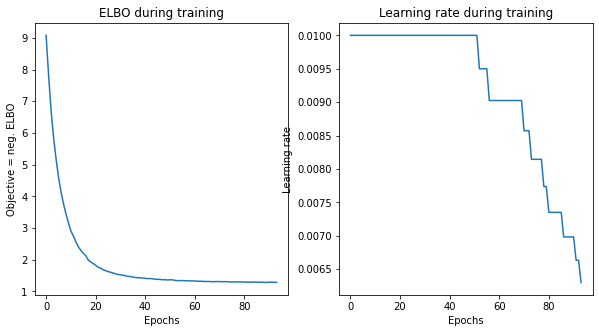

Training Set


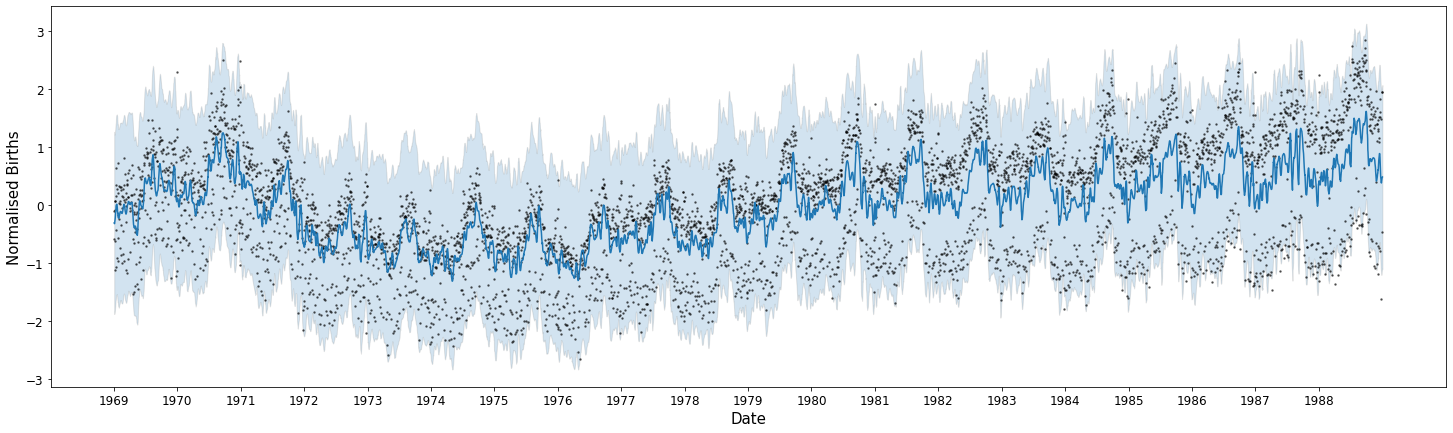

Testing Set


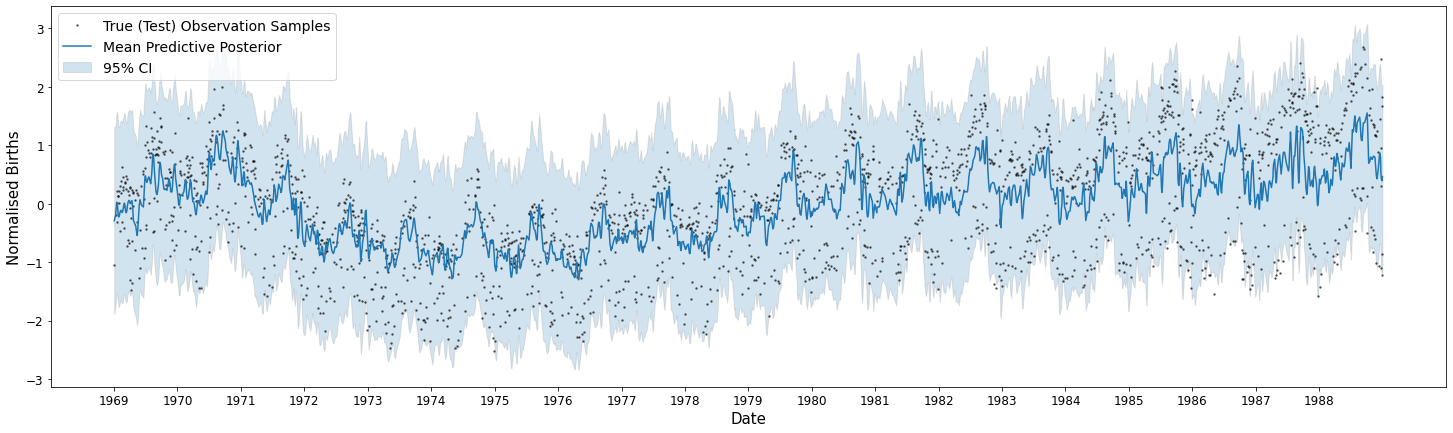

Train ELBO, MSE, MAE:  -6577.7477985479345 0.5163045837055643 0.6027473725305889 0.6899316034430695 19.852327043091726
Test ELBO, MSE, MAE:  -7464.511480487134 0.6864197448683762 0.6979897959099562 0.6995674896924821 20.001107211359155


------------------------


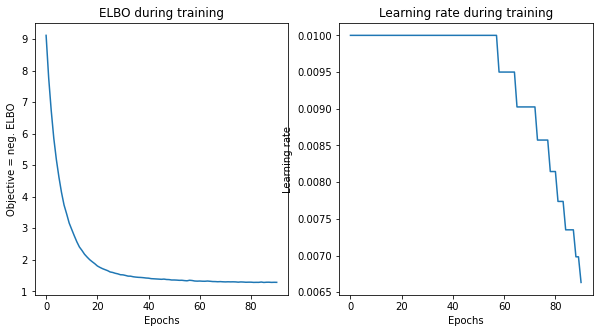

Training Set


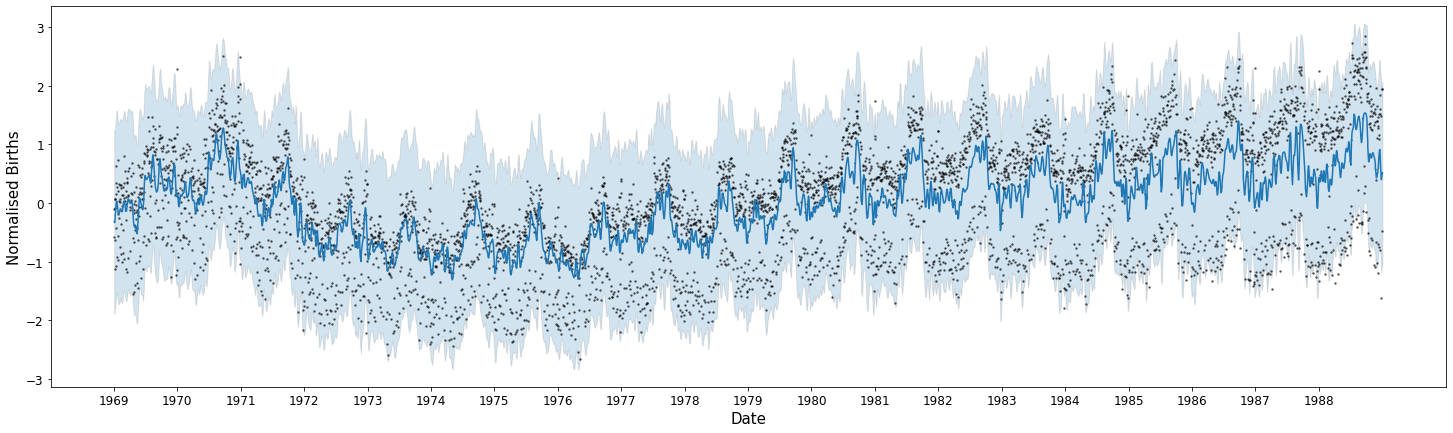

Testing Set


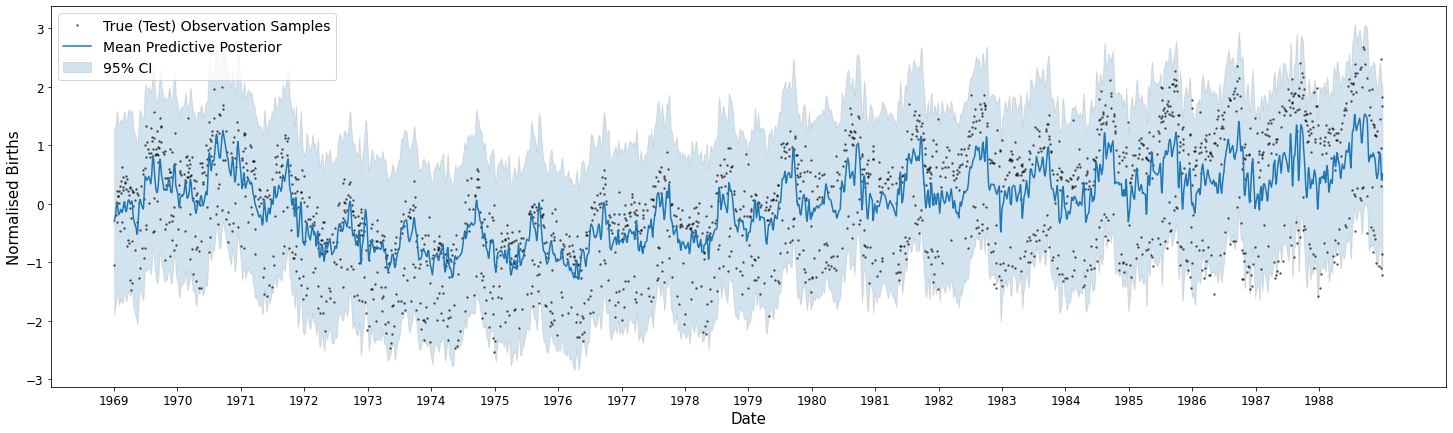

Train ELBO, MSE, MAE:  -6580.175941494033 0.5159047887935259 0.602246247316293 0.6900061515604132 19.932502176796955
Test ELBO, MSE, MAE:  -7466.8568553906125 0.6860993537882595 0.6972425836477382 0.6997631504908873 20.091307475091906


------------------------


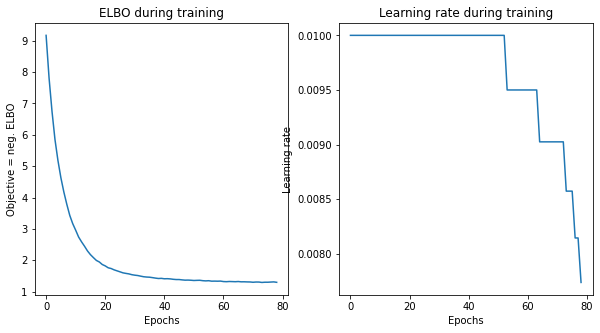

Training Set


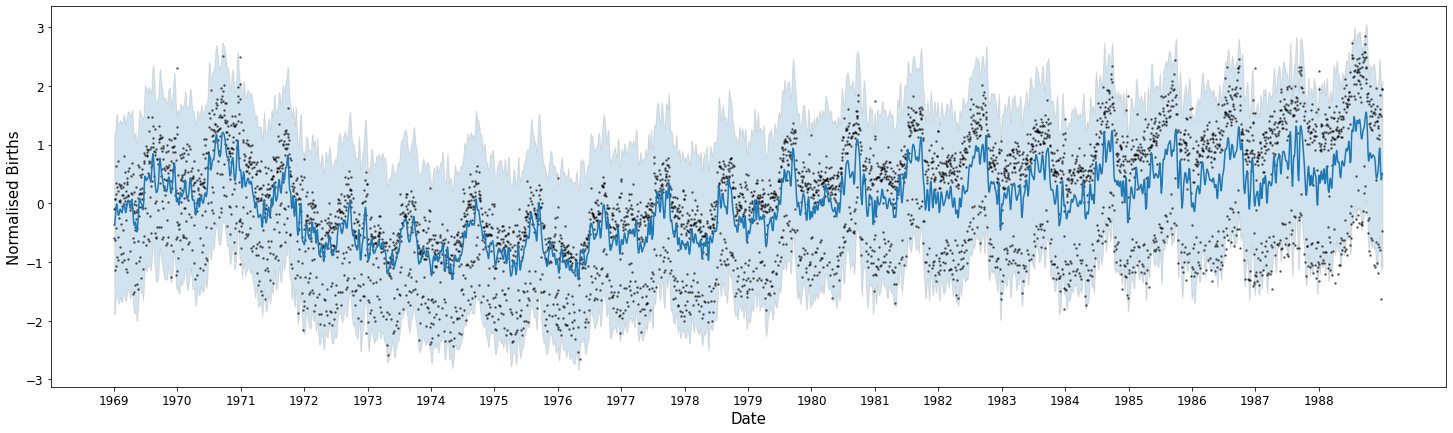

Testing Set


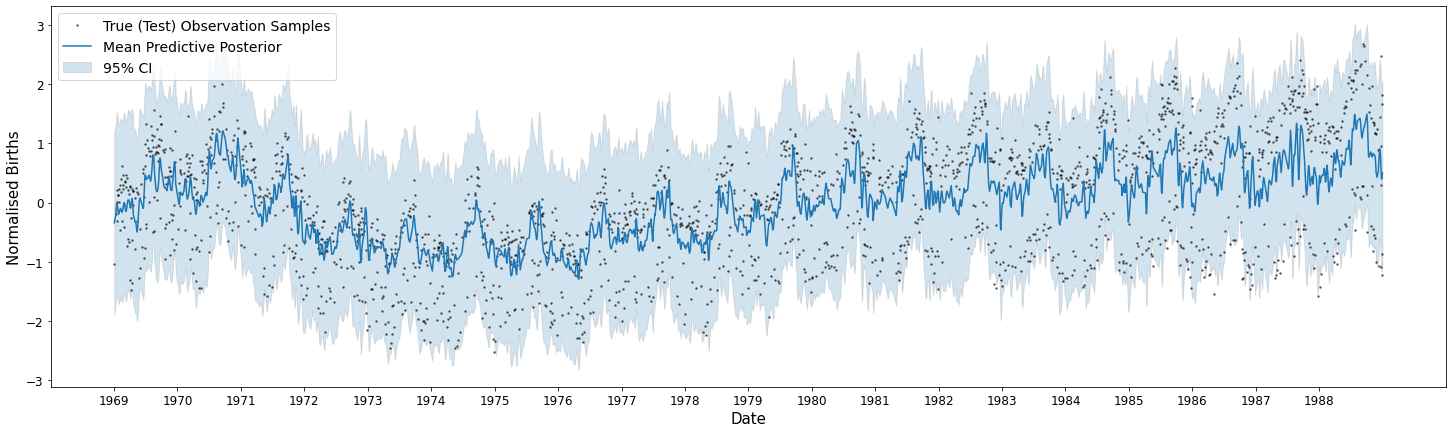

Train ELBO, MSE, MAE:  -6624.74783150235 0.5159200669488809 0.6026345151255674 0.6912499508481509 20.54974742729051
Test ELBO, MSE, MAE:  -7564.79010645518 0.6896824216500254 0.6997904894125858 0.7005353243623483 20.63677556742501


------------------------


In [15]:
kernel_list1 = [gpflow.kernels.RBF(), gpflow.kernels.Matern12(), gpflow.kernels.Periodic(gpflow.kernels.Matern32())]
kernel_list2 = [gpflow.kernels.RBF(), gpflow.kernels.RBF(), gpflow.kernels.Periodic(gpflow.kernels.Matern32())]

for k1 in kernel_list1:
    print(k1)
    build_train_2layer_dgp(k1, gpflow.kernels.RBF(), num_inducing=1000, batch_size=500)
    print('------------------------')

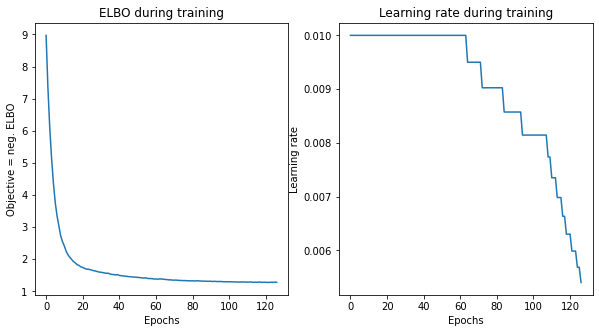

Training Set


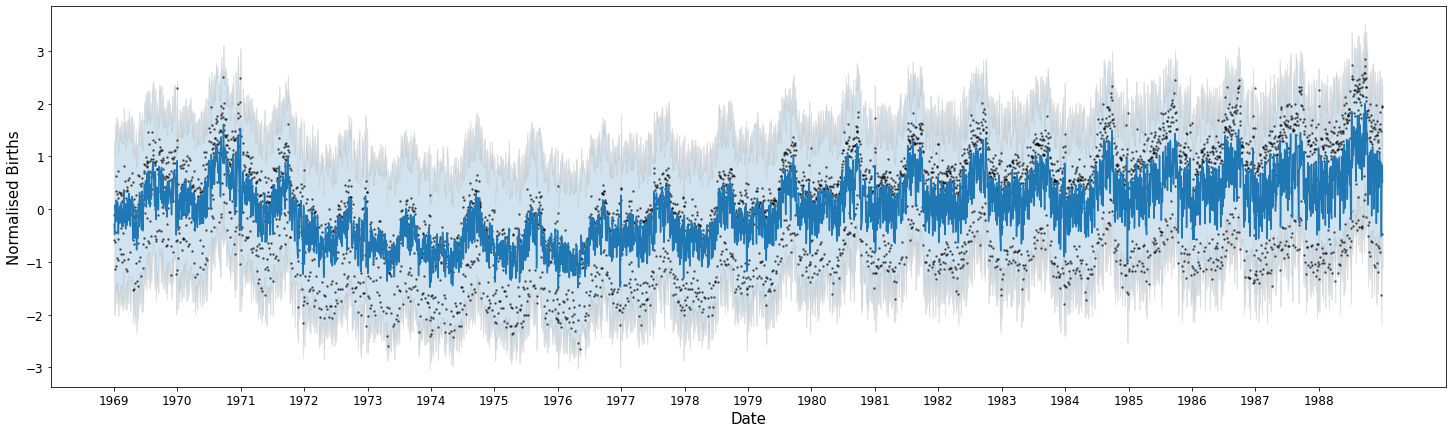

Testing Set


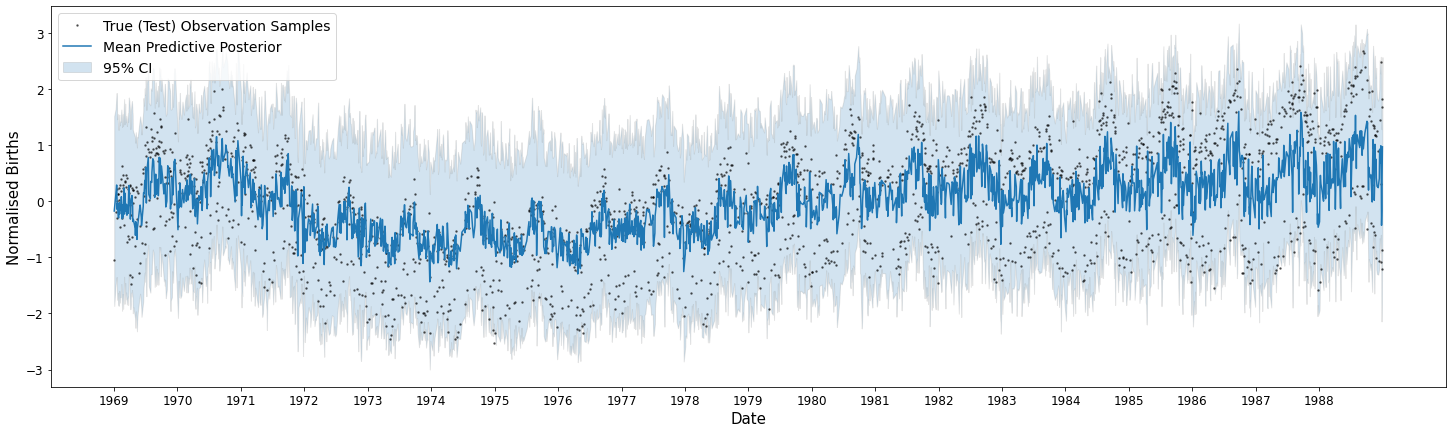

Train ELBO, MSE, MAE:  -6554.711129565501 0.29973401479077133 0.4499637003315714 0.6927853961795223 19.63409843846304
Test ELBO, MSE, MAE:  -8700.285775584733 0.6278561708699794 0.6613258479943303 0.6755198000831257 16.33819396345037


In [18]:
build_train_2layer_dgp(gpflow.kernels.Periodic(gpflow.kernels.Matern32()), gpflow.kernels.RBF(), num_inducing=3000, batch_size=500)

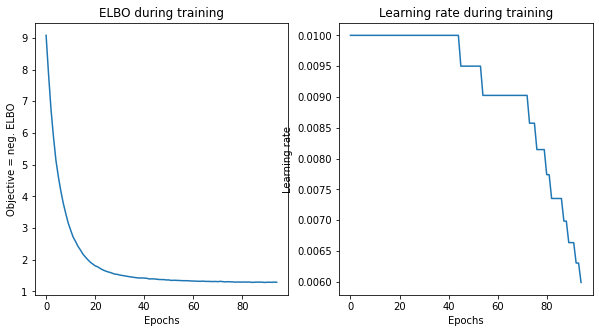

Training Set


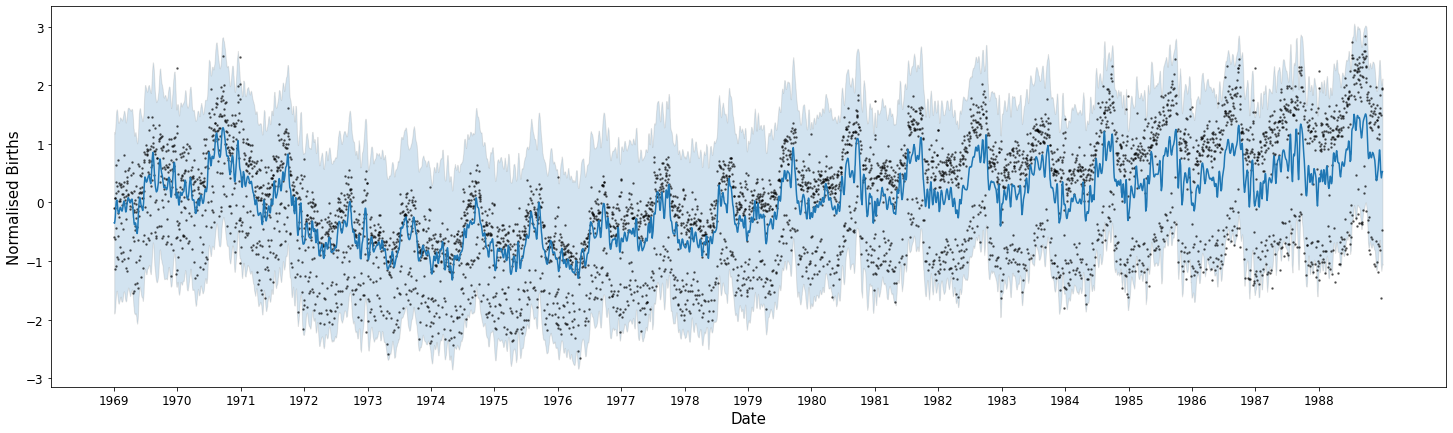

Testing Set


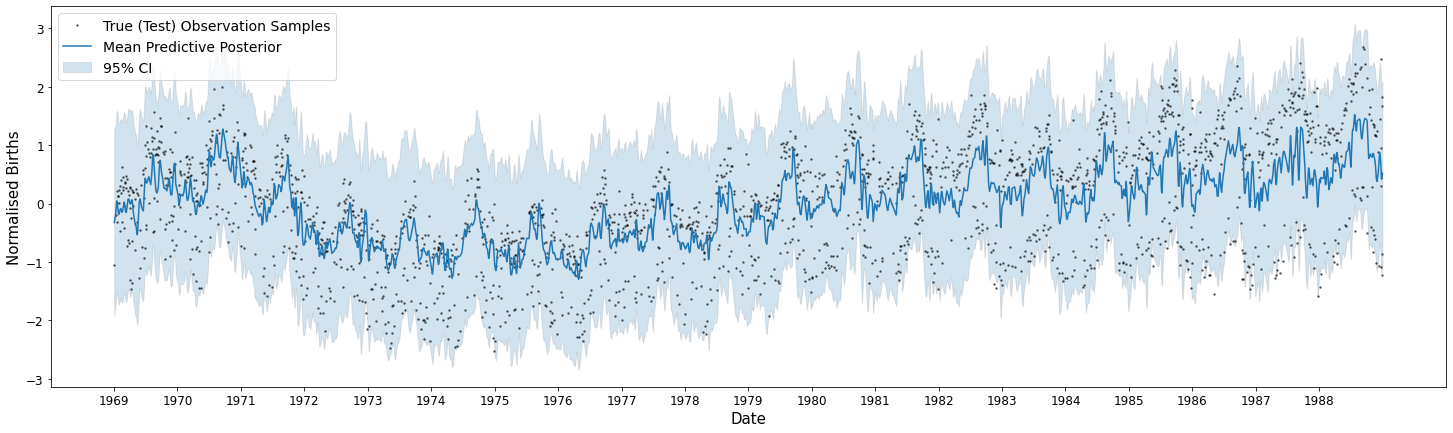

Train ELBO, MSE, MAE:  -6575.327037215552 0.5162500242221032 0.6023957552964461 0.6896776902272395 19.833239547042623
Test ELBO, MSE, MAE:  -7454.533051950235 0.6851402948512131 0.6970809743568441 0.6994877211206343 19.99047215488305


------------------------


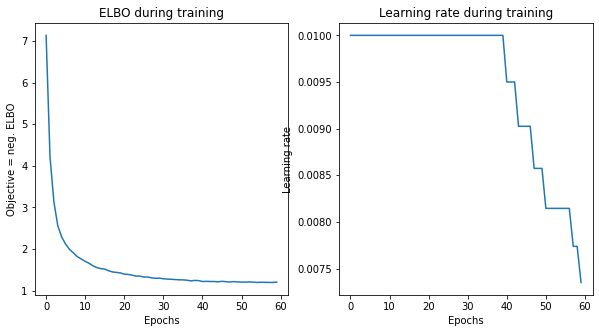

Training Set


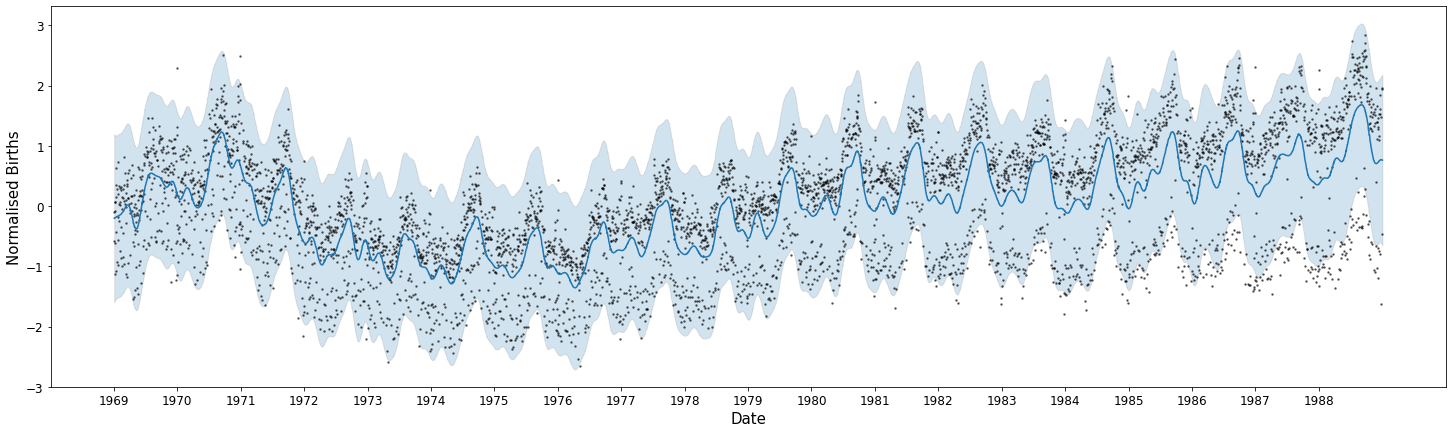

Testing Set


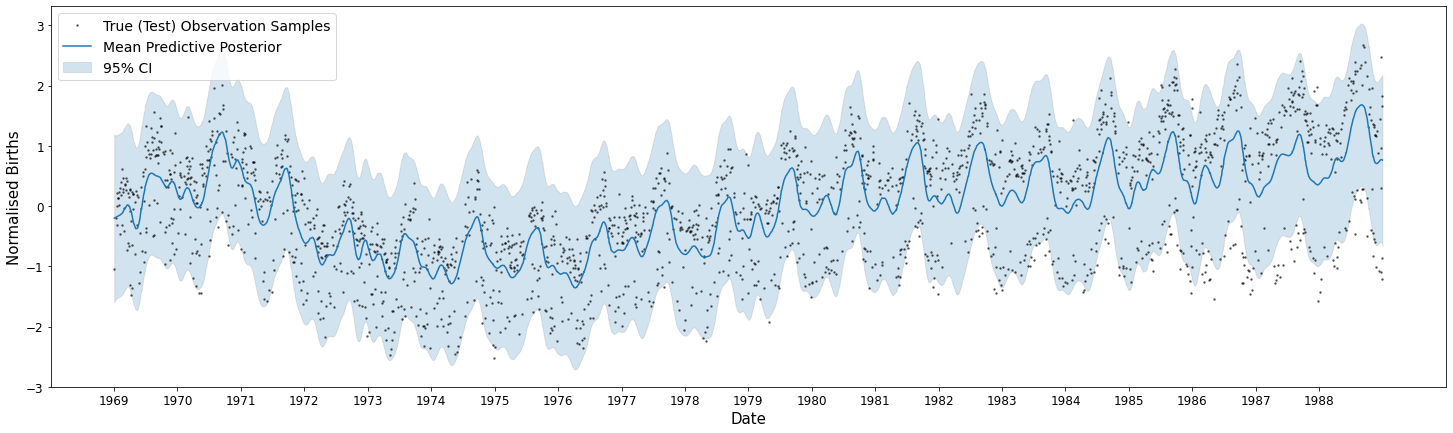

Train ELBO, MSE, MAE:  -6124.0431656254295 0.5429340377020976 0.6207936149542755 0.7281571373402597 27.753697399078114
Test ELBO, MSE, MAE:  -6412.670577643913 0.5938529664084989 0.647987496015093 0.7442593604733789 28.830992927167138


------------------------


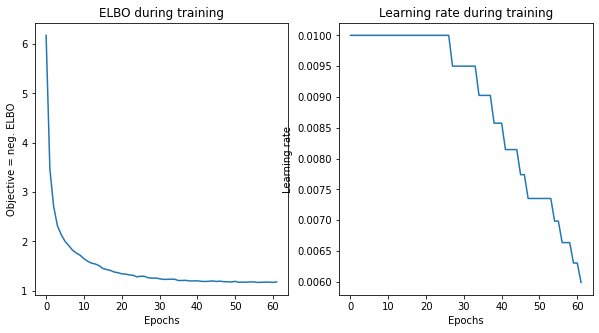

Training Set


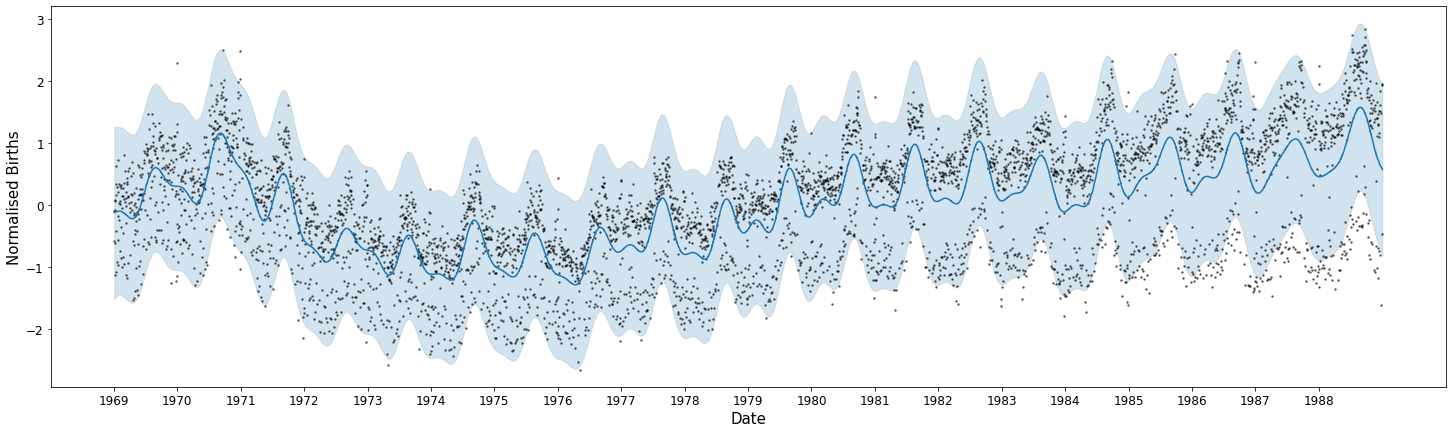

Testing Set


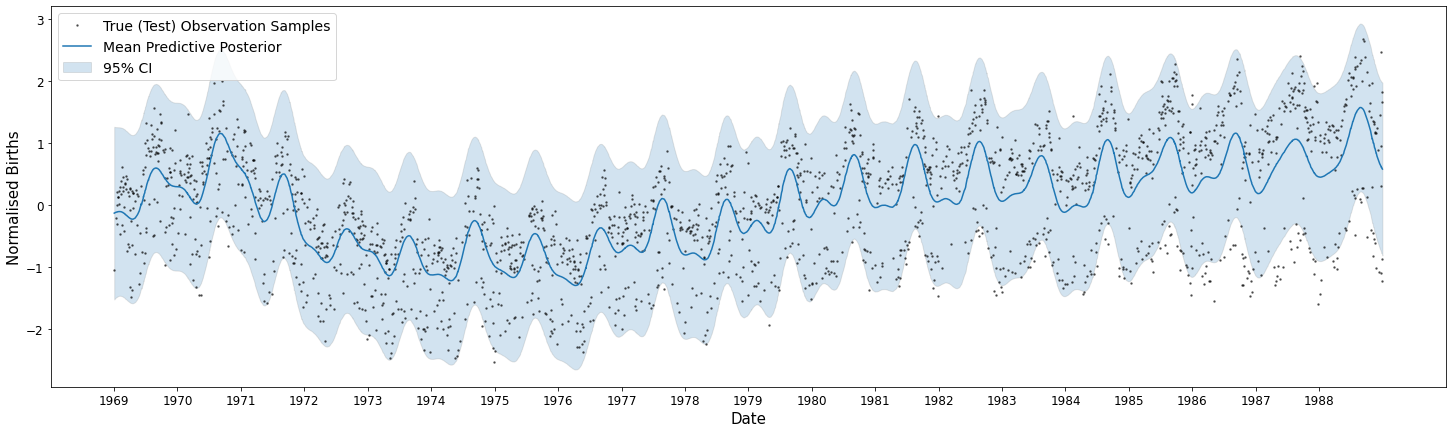

Train ELBO, MSE, MAE:  -5992.361755911206 0.5530711369835547 0.6247961568378065 0.7259522453436685 27.589736190531312
Test ELBO, MSE, MAE:  -6173.768487411045 0.5856030125542545 0.6423584679254188 0.7423920862541434 28.716234215994458


------------------------


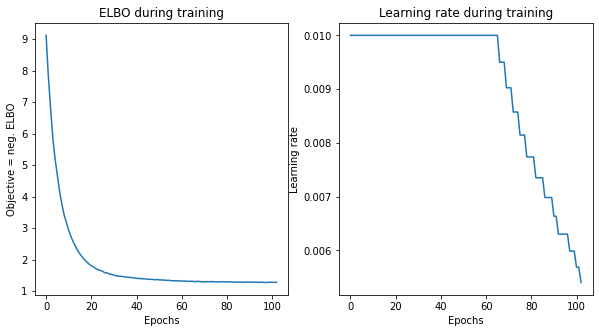

Training Set


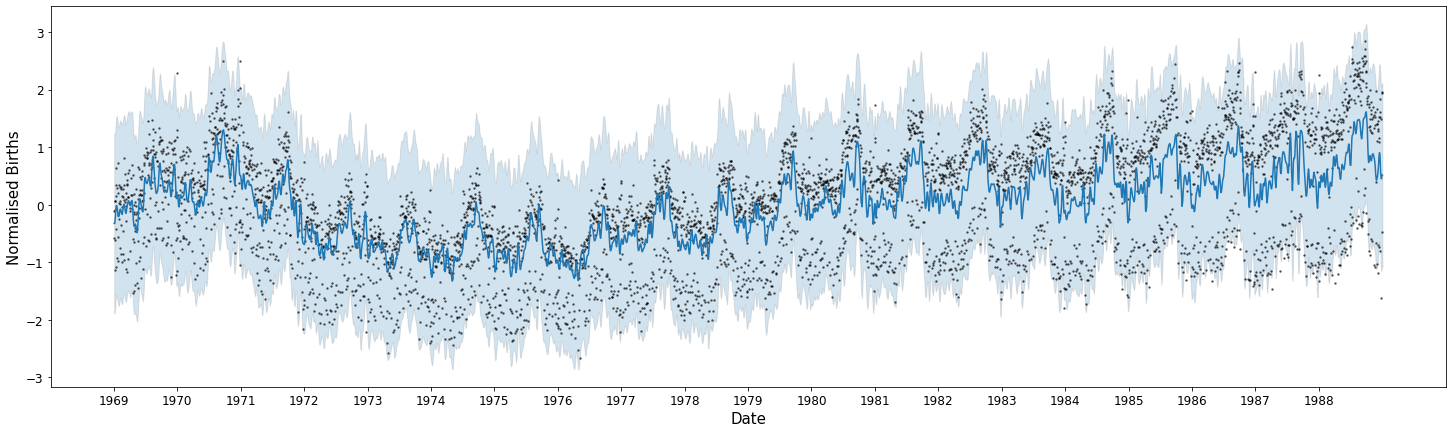

Testing Set


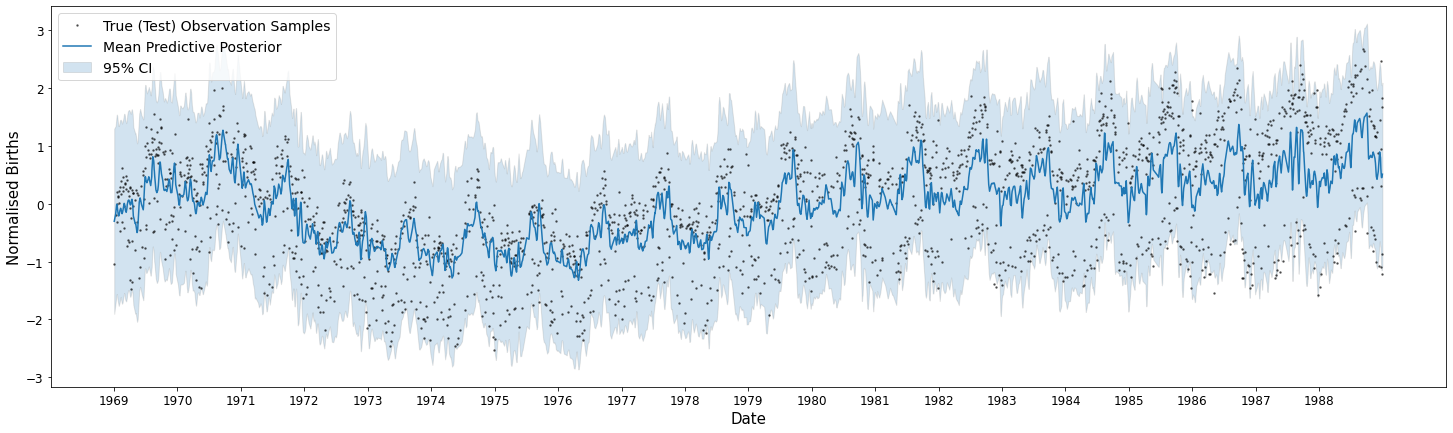

Train ELBO, MSE, MAE:  -6555.099558335141 0.5161906806810591 0.6024603845992386 0.6891995894477849 19.545125460887483
Test ELBO, MSE, MAE:  -7421.957071666939 0.6861198408052216 0.6976671572129111 0.6989862662046658 19.72601097554478


------------------------


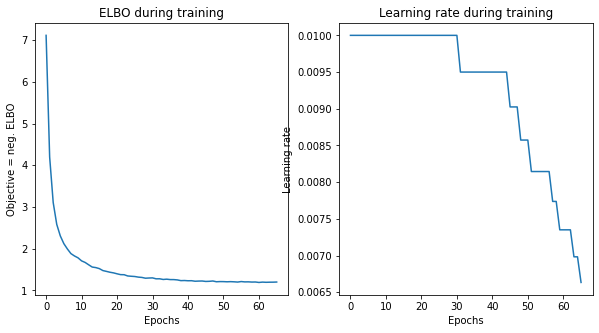

Training Set


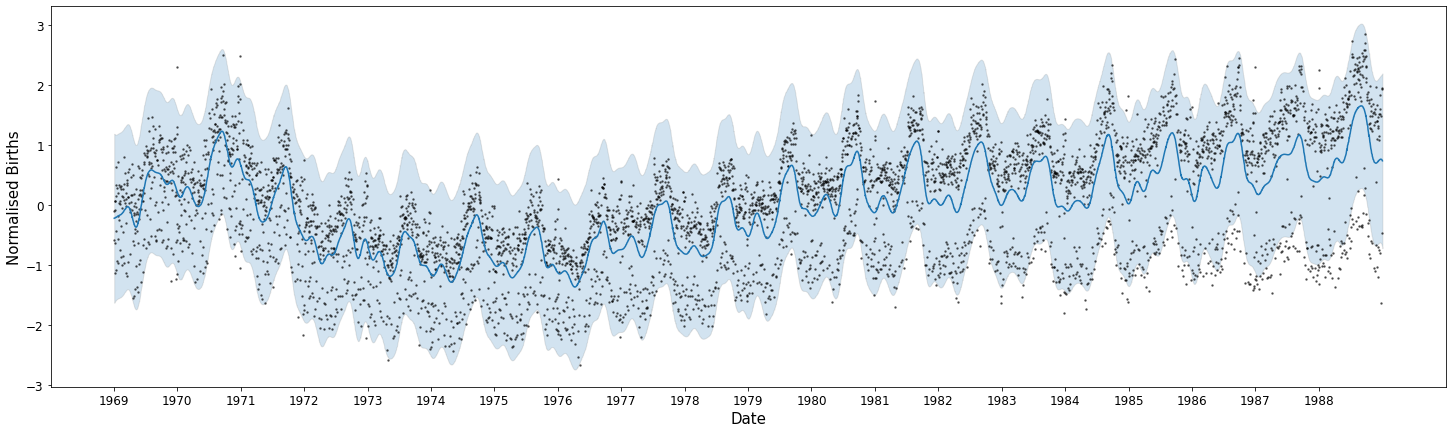

Testing Set


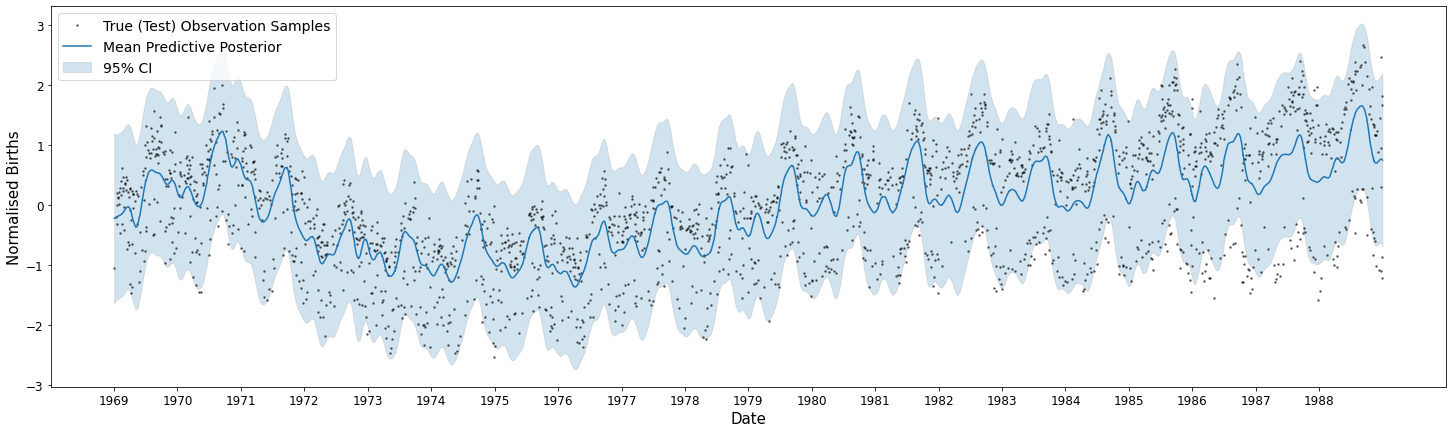

Train ELBO, MSE, MAE:  -6102.473888045384 0.5427540504487811 0.6217304012988355 0.7252267187811109 26.929691342183375
Test ELBO, MSE, MAE:  -6385.346454030021 0.5937032018762403 0.648692435172052 0.7410674819883099 27.98903361260589


------------------------


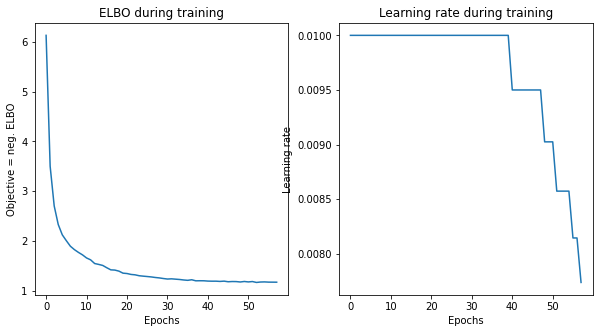

Training Set


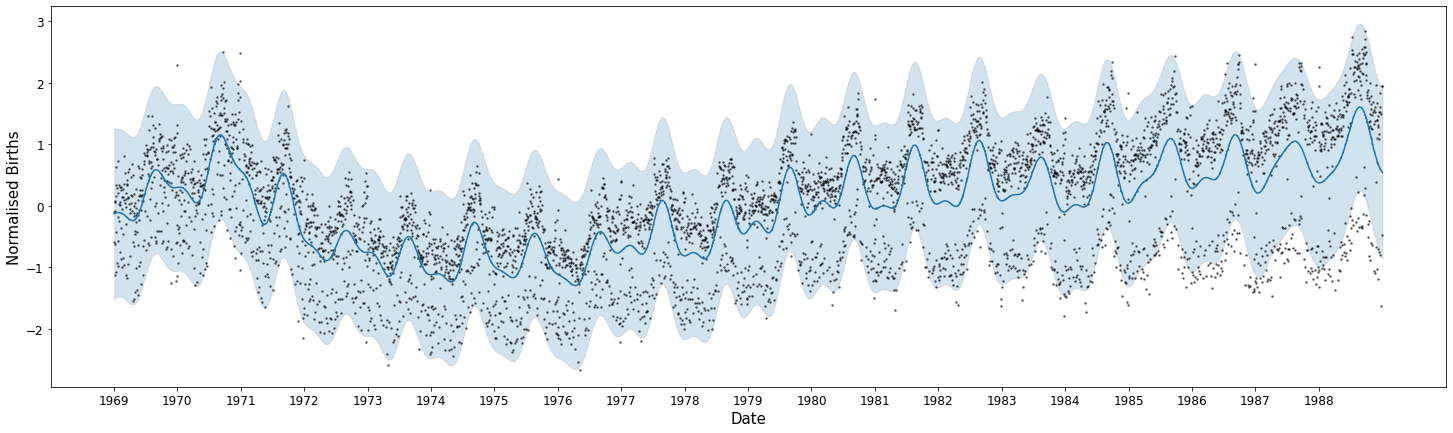

Testing Set


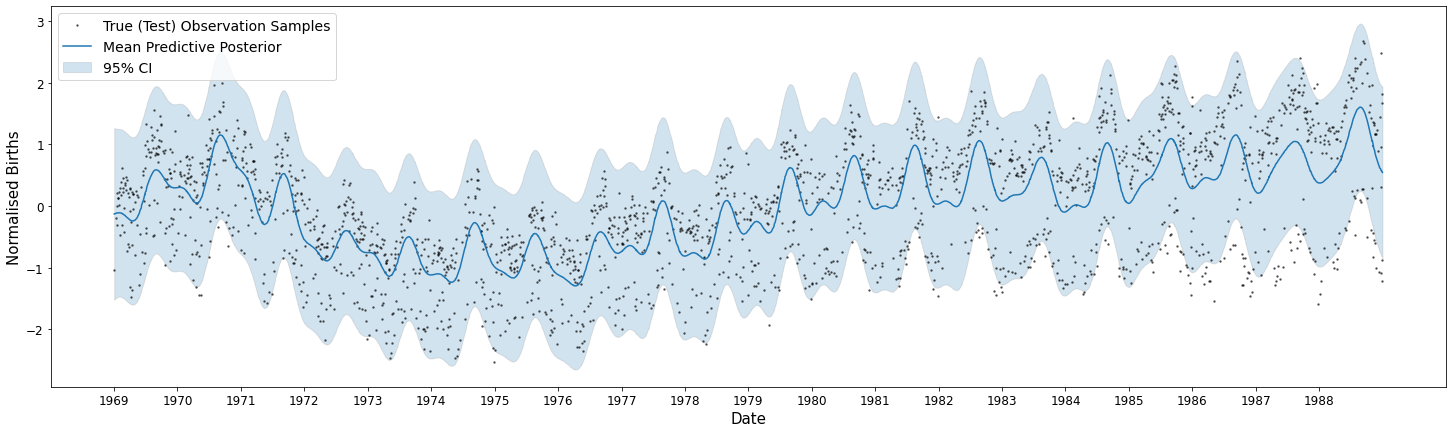

Train ELBO, MSE, MAE:  -5989.289023526153 0.5530968882388076 0.626268944640511 0.7260471571475932 27.47185655811747
Test ELBO, MSE, MAE:  -6172.620434722569 0.5866392479001113 0.6441775261317109 0.7422705646393952 28.57610537988172


------------------------


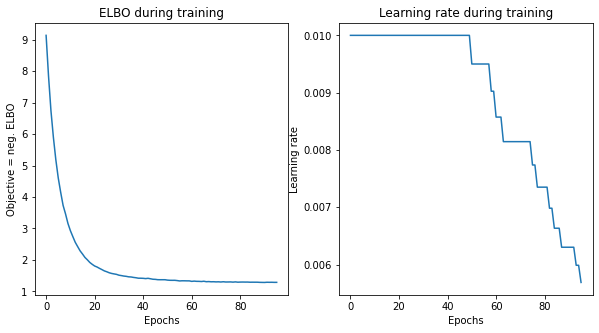

Training Set


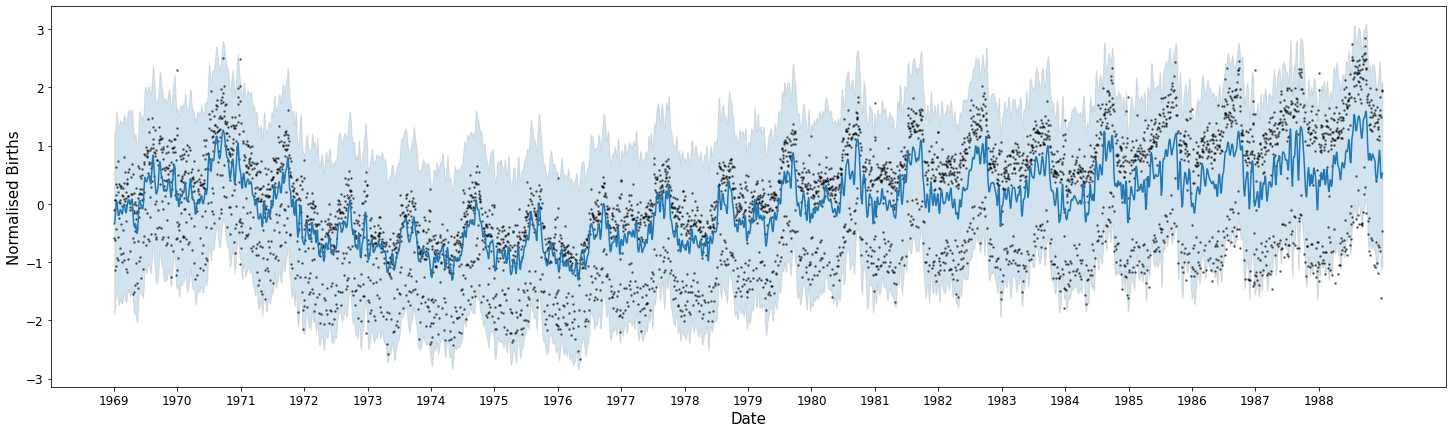

Testing Set


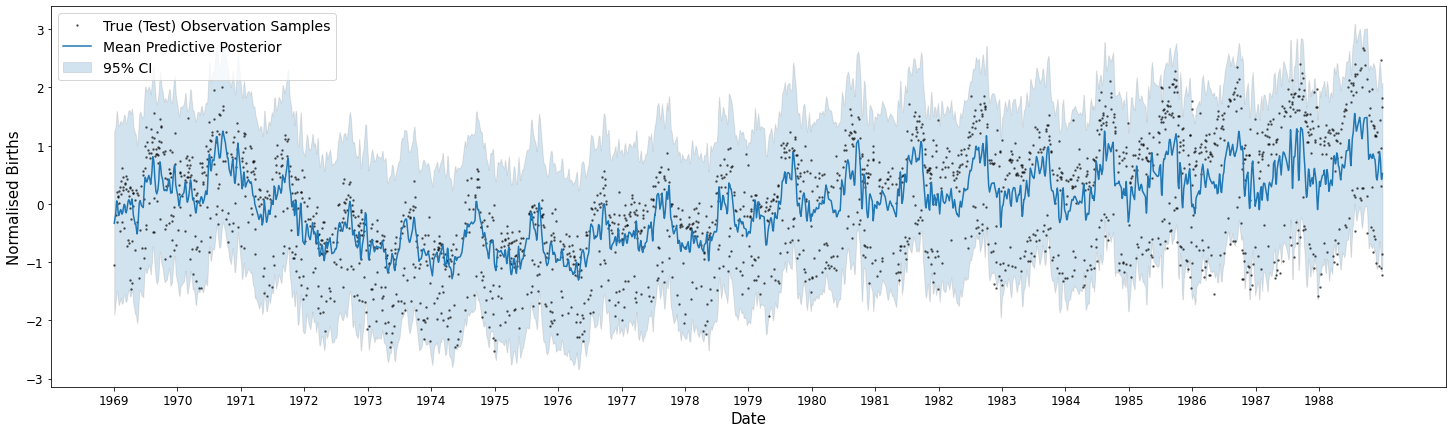

Train ELBO, MSE, MAE:  -6578.521177955123 0.5160686427192644 0.6028416077815475 0.690319737826806 19.94854867898653
Test ELBO, MSE, MAE:  -7469.51144995327 0.6867856933832334 0.6983955217980724 0.6999553248580802 20.10781158426128


------------------------


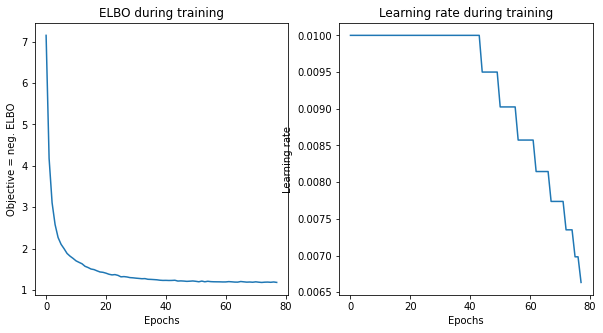

Training Set


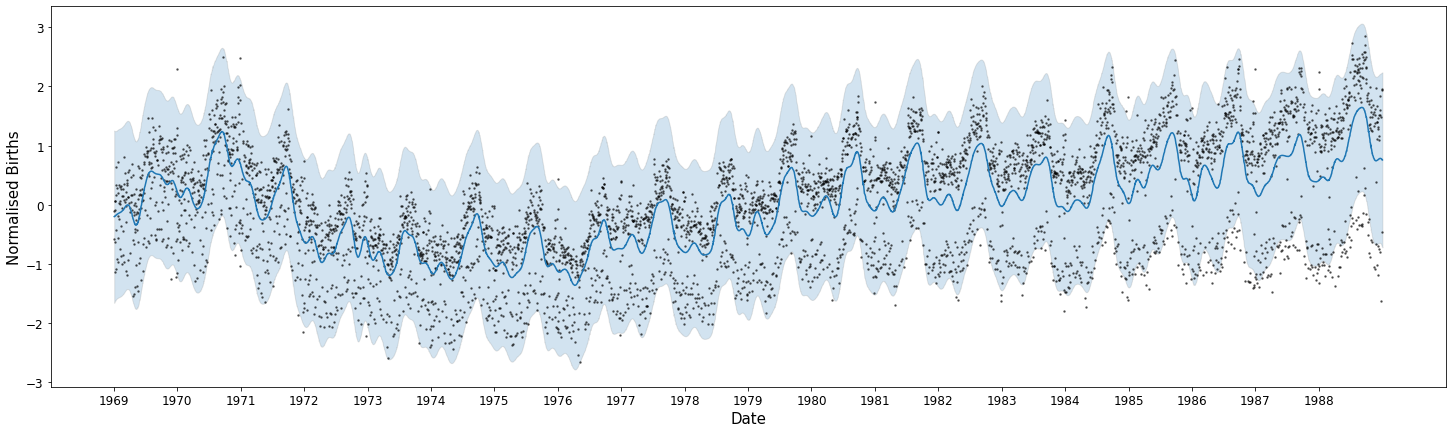

Testing Set


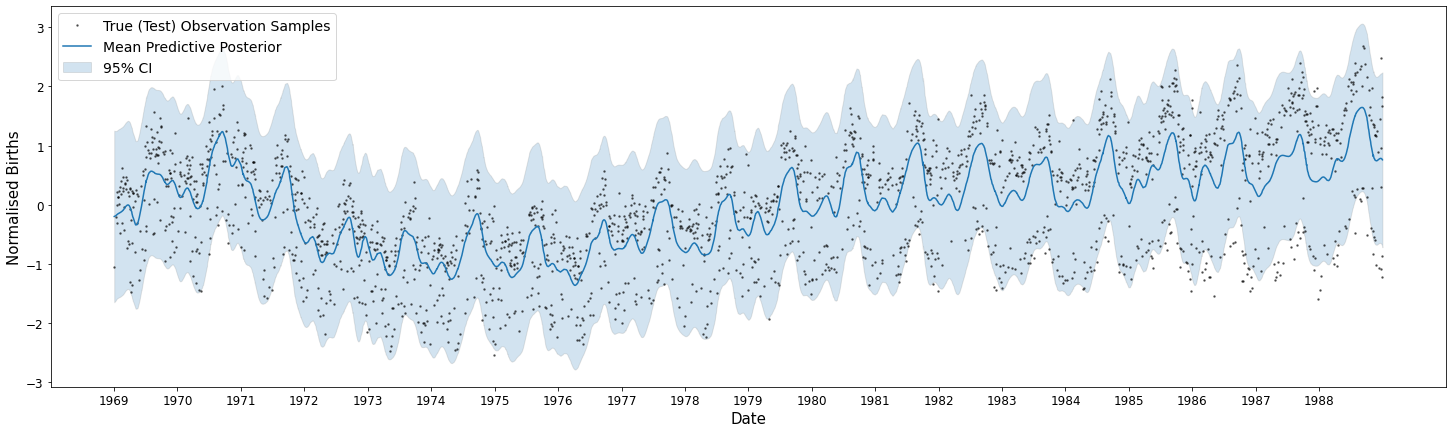

Train ELBO, MSE, MAE:  -6072.517153202282 0.5426551615907192 0.6211417369000568 0.7209197335144532 25.22243148765152
Test ELBO, MSE, MAE:  -6333.958508299667 0.592918831397693 0.6474836682677063 0.736804327624432 26.284448425595397


------------------------


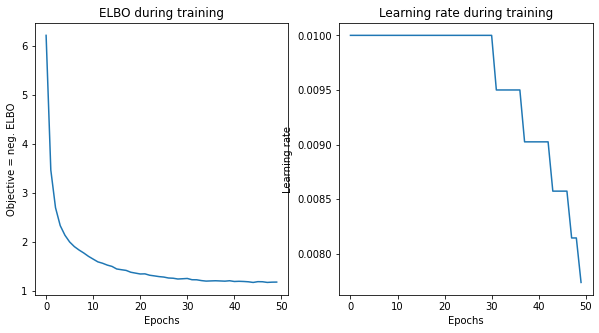

Training Set


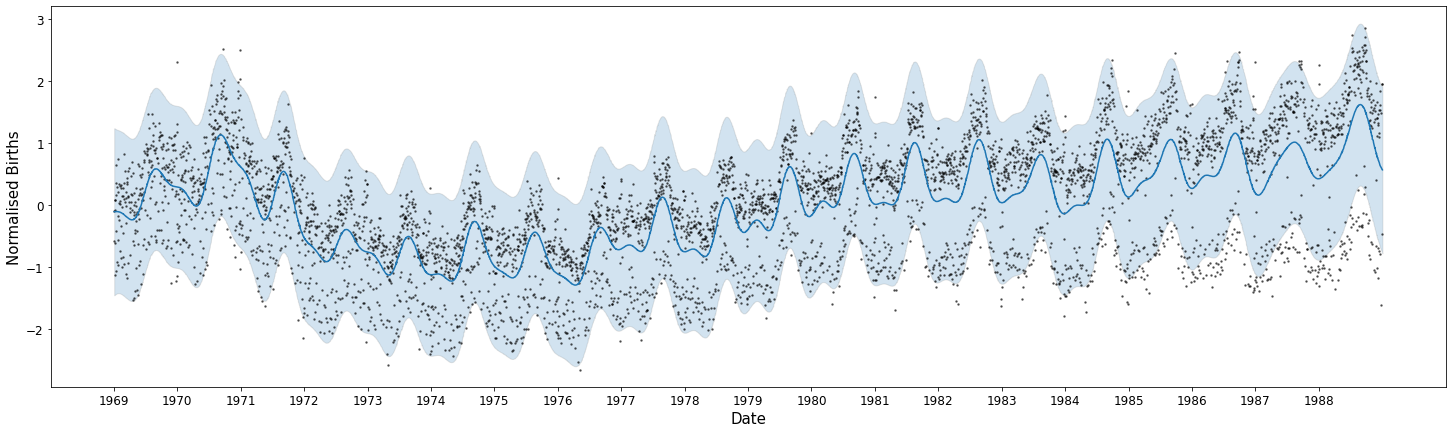

Testing Set


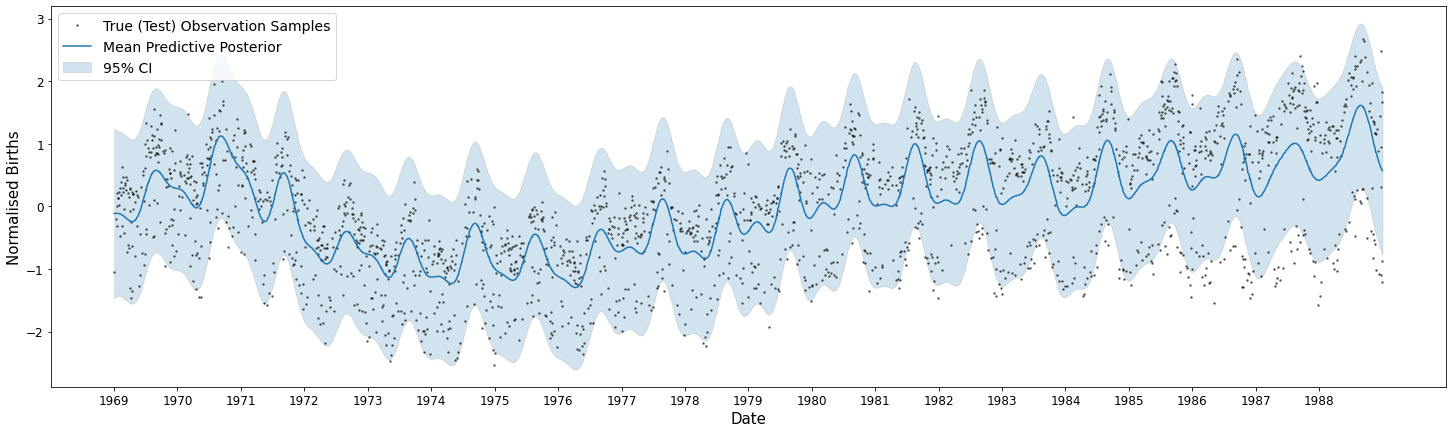

Train ELBO, MSE, MAE:  -6037.945026513107 0.5534415946258321 0.6248500779561843 0.7302279062335033 29.303276940556678
Test ELBO, MSE, MAE:  -6237.541931852826 0.5873225049210025 0.6432468689099151 0.7464730492389755 30.441839769034047


------------------------


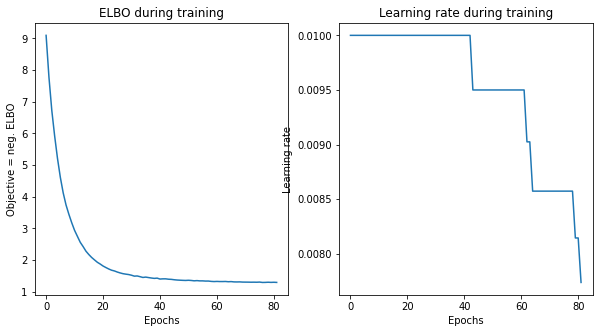

Training Set


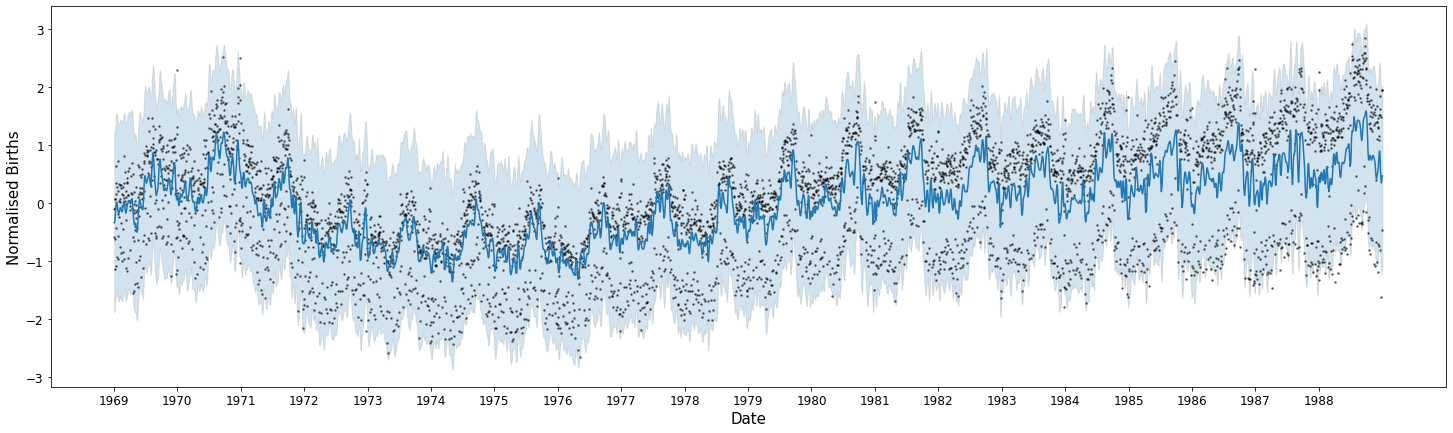

Testing Set


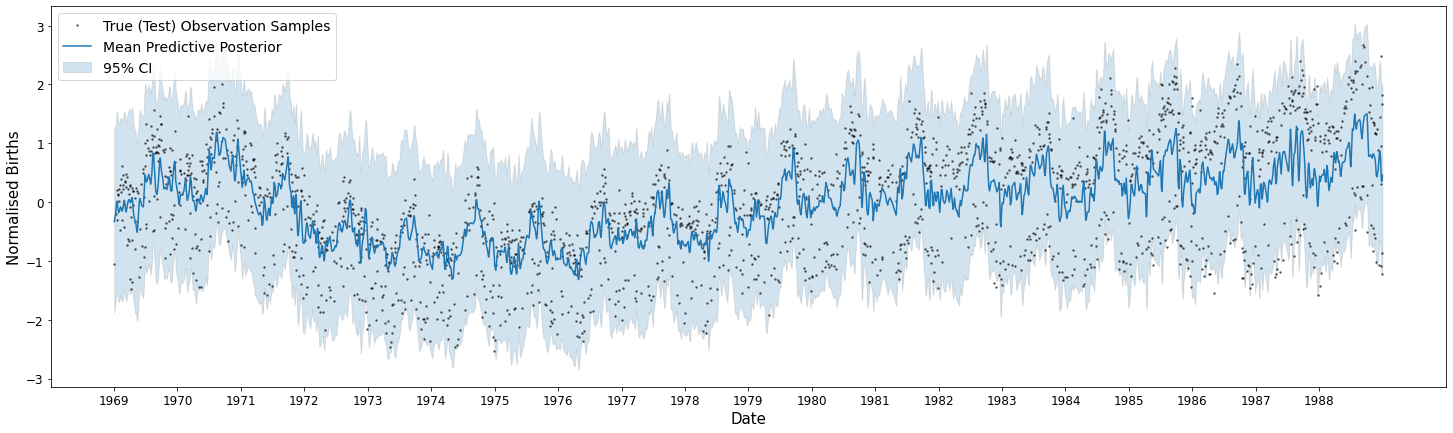

Train ELBO, MSE, MAE:  -6611.9610456131595 0.5155112718807393 0.6021424487759248 0.6911184339638516 20.428734997428926
Test ELBO, MSE, MAE:  -7543.676701857959 0.6901991890952771 0.6996393700988074 0.7000872509227187 20.51121530182748


------------------------


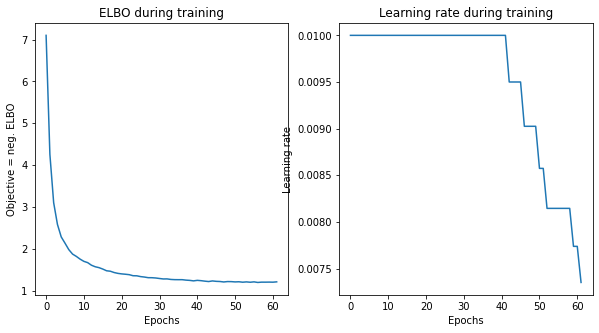

Training Set


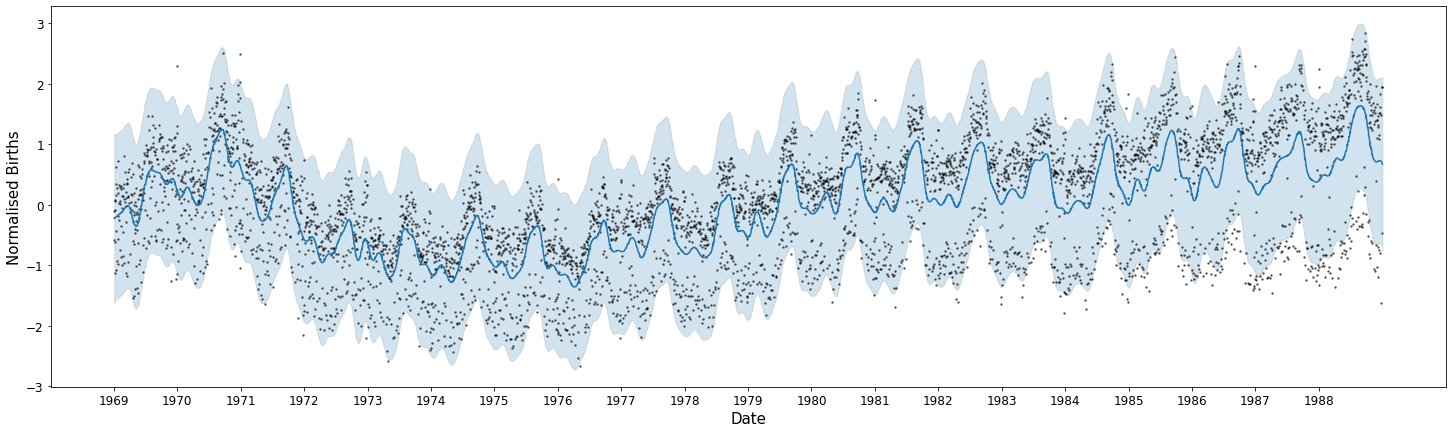

Testing Set


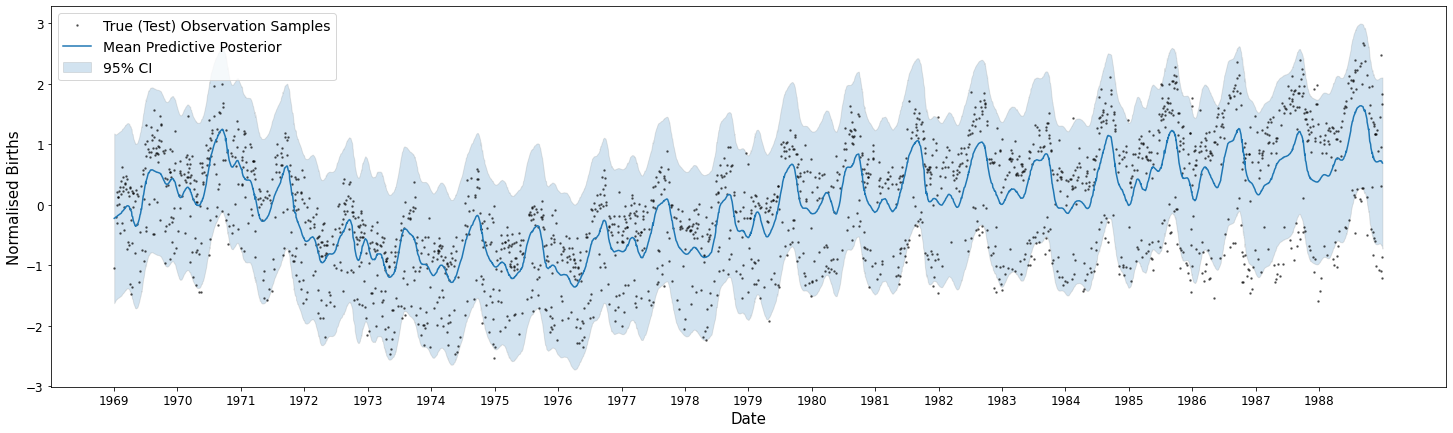

Train ELBO, MSE, MAE:  -6109.79621457305 0.5421518272570565 0.6212871889883661 0.7265280017586455 27.30644944305632
Test ELBO, MSE, MAE:  -6400.908201663649 0.593083988328114 0.6487248312511416 0.7427908332014974 28.379075869785286


------------------------


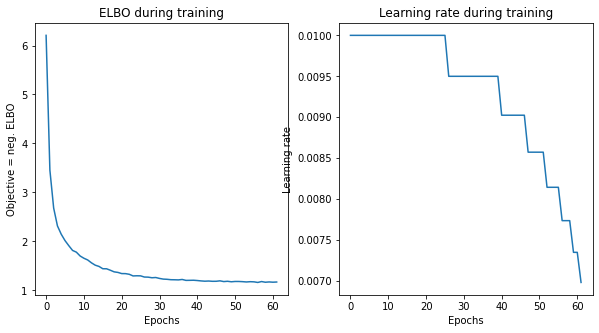

Training Set


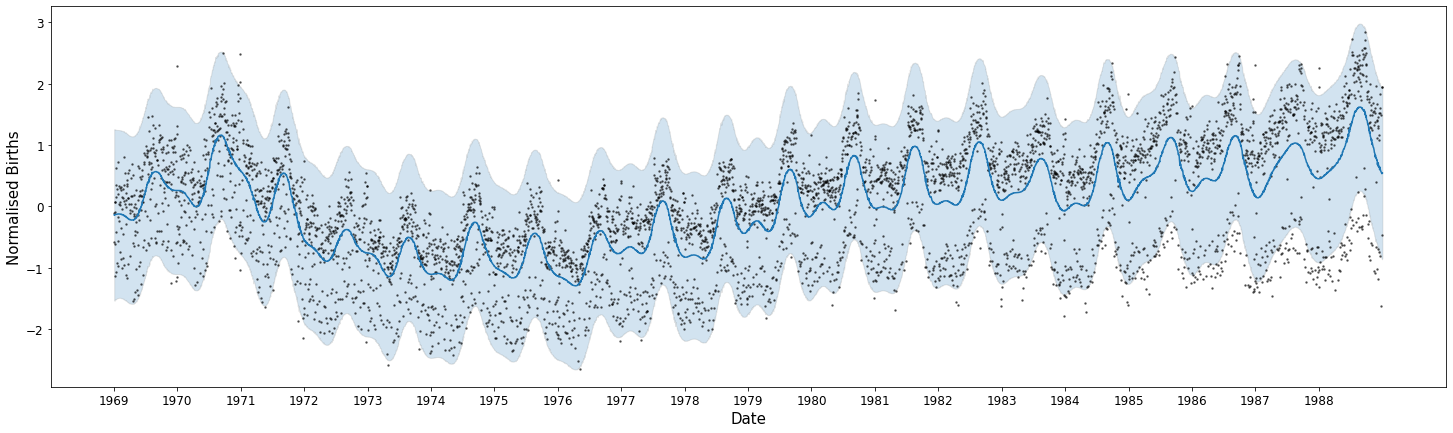

Testing Set


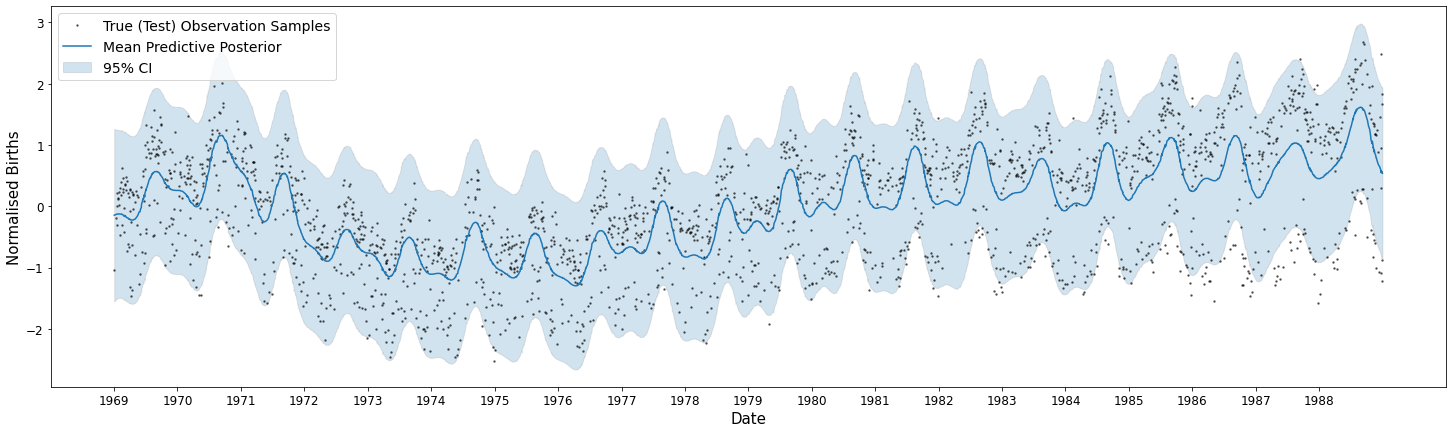

Train ELBO, MSE, MAE:  -5982.888410428819 0.5519132872594252 0.624803978924981 0.7257844467852755 27.171303085759586
Test ELBO, MSE, MAE:  -6155.579661043835 0.5837781724860255 0.6420411759416795 0.7419462205943115 28.28296492887208


------------------------


In [16]:
for p in [1, 77, 180, 365]:
    for l in [1, 30, 77]:
        build_train_2layer_dgp(gpflow.kernels.Periodic(gpflow.kernels.Matern32(), period=p), gpflow.kernels.RBF(lengthscales=l), num_inducing=1000, batch_size=500)
        print('------------------------')

# 3 layer

In [ ]:
def build_train_3layer_dgp(kernel1, kernel2, kernel3, callbacks=None, num_inducing=1000, batch_size=500):
    Z = np.linspace(x_train.min(), x_train.max(), num_inducing).reshape(-1, 1)

    # layer 1 set up
    inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer1 = gpflux.layers.GPLayer(
        kernel1, 
        inducing_variable1, 
        num_data=len(x_train), 
        num_latent_gps=y.shape[1]
    )

    # layer 2 set up
    inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer2 = gpflux.layers.GPLayer(
        kernel2,
        inducing_variable2,
        num_data=len(x_train),
        num_latent_gps=y.shape[1]
    )

    # layer 3 set up
    inducing_variable3 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer3 = gpflux.layers.GPLayer(
        kernel3,
        inducing_variable3,
        num_data=len(x_train),
        num_latent_gps=y.shape[1]
    )

    # model construction
    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
    three_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2, gp_layer3], likelihood_layer)

    model = three_layer_dgp.as_training_model()
    model.compile(tf.optimizers.Adam(0.1))

    if callbacks:
        history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=50, verbose=0, callbacks=callbacks)
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].plot(history.history["loss"])
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Objective = neg. ELBO")
        ax[0].set_title('ELBO during training')
        ax[1].plot(history.history["lr"])
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Learning rate")
        ax[1].set_title('Learning rate during training')
        plt.show()
    else:
        history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=50, verbose=0)
        plt.plot(history.history["loss"])
        plt.xlabel("Epochs")
        plt.ylabel("Objective = neg. ELBO")
        plt.title('ELBO during training')
        plt.show()

    model = three_layer_dgp.as_prediction_model()

    print('Training Set')
    fitted_values = model(x_train)
    mean_train = fitted_values.f_mean.numpy().squeeze()
    var_train = fitted_values.f_var.numpy().squeeze()
    plot_model(x_train, y_train, mean_train, var_train, pos, labels)

    print('Testing Set')
    pred = model(x_test)
    mean_test = pred.f_mean.numpy().squeeze()
    var_test = pred.f_var.numpy().squeeze()
    plot_model(x_test, y_test, mean_test, var_test, pos, labels)

    print('Train ELBO, MSE, MAE: ', three_layer_dgp.elbo((x_train, y_train)).numpy(), 
                                    mean_squared_error(y_train, mean_train), 
                                    mean_absolute_error(y_train, mean_train))

    print('Test ELBO, MSE, MAE: ', three_layer_dgp.elbo((x_test, y_test)).numpy(), 
                                    mean_squared_error(y_test, mean_test), 
                                    mean_absolute_error(y_test, mean_test))
    
    #print_summary(three_layer_dgp, fmt="notebook")

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4057610/1667748621.py:33: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2

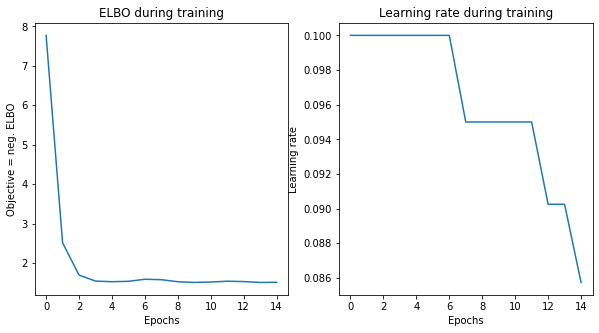

Training Set


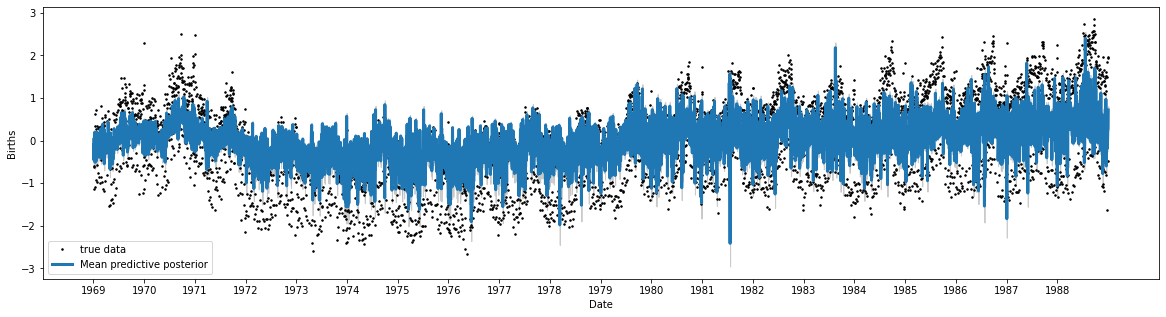

Testing Set


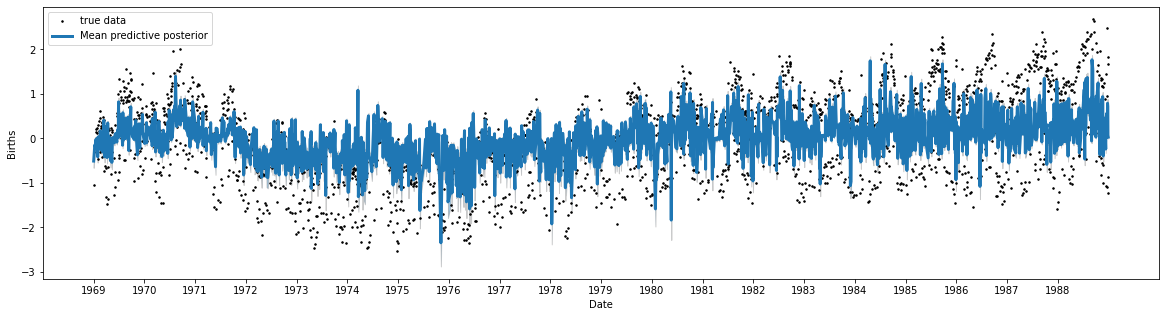

Train ELBO, MSE, MAE:  -7790.2360051165015 0.7936123896219729 0.7271185118132886
Test ELBO, MSE, MAE:  -8027.054516518935 0.8796033853996612 0.7702376502195143


In [ ]:
# using callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
]

kernel1 = gpflow.kernels.Periodic(gpflow.kernels.RBF())
kernel2 = gpflow.kernels.RBF()
kernel3 = gpflow.kernels.RBF()

build_train_3layer_dgp(kernel1, kernel2, kernel3, num_inducing=1000, callbacks=callbacks, batch_size=500)